<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/daging_sapi1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [6]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fe20156f790>)

In [7]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [8]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [9]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.daging_sapi_kualitas_1.values
date = dataset.index

## Train test val split

In [10]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


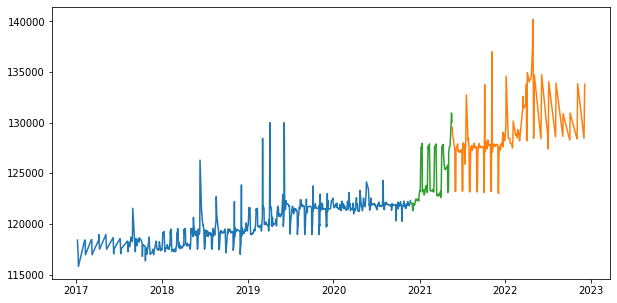

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [12]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

## model 

In [13]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


### SGD

In [14]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [15]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 14s 219ms/step - loss: 0.1504 - mae: 0.3859 - mape: 90.8236 - val_loss: 0.2057 - val_mae: 0.3955 - val_mape: 77.6918
Epoch 2/30
44/44 [==============================] - 10s 216ms/step - loss: 0.0951 - mae: 0.3063 - mape: 71.9653 - val_loss: 0.1553 - val_mae: 0.3263 - val_mape: 58.7477
Epoch 3/30
44/44 [==============================] - 17s 398ms/step - loss: 0.0601 - mae: 0.2427 - mape: 56.9355 - val_loss: 0.1232 - val_mae: 0.2806 - val_mape: 48.6829
Epoch 4/30
44/44 [==============================] - 12s 261ms/step - loss: 0.0383 - mae: 0.1927 - mape: 45.0731 - val_loss: 0.1023 - val_mae: 0.2613 - val_mape: 49.0726
Epoch 5/30
44/44 [==============================] - 8s 187ms/step - loss: 0.0249 - mae: 0.1545 - mape: 36.0638 - val_loss: 0.0878 - val_mae: 0.2457 - val_mape: 49.4375
Epoch 6/30
44/44 [==============================] - 9s 200ms/step - loss: 0.0163 - mae: 0.1235 - mape: 28.7360 - val_loss: 0.0777 - val_mae: 0.2330 - val_ma

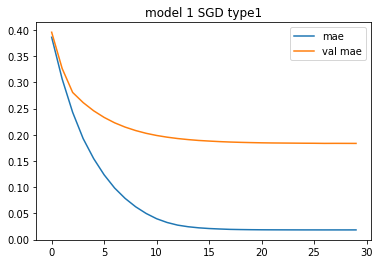

In [16]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

In [17]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
test_beras_ = scal_range.fit_transform(forecast.reshape(-1, 1))

131/131 [==============================] - 3s 22ms/step
2631.2751 2.0202935 3430.2603399742125


,date,actual,prediction
0,2021-05-20,129550,122750.390625
1,2021-05-21,128900,122733.203125
2,2021-05-24,128500,122792.085938
3,2021-05-25,128350,122853.296875
4,2021-05-27,127950,122931.953125
...,...,...,...
229,2022-11-02,128700,127619.421875
230,2022-11-03,130950,127690.125000
231,2022-11-04,133850,127586.976562
232,2022-12-01,128450,127642.250000


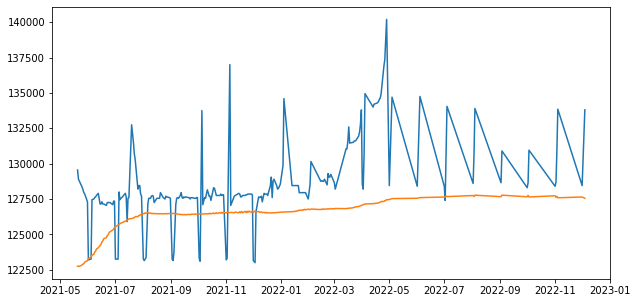

In [22]:
prediction = forecast_predict(model, test_beras_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_beras = pd.DataFrame()
data_new_beras['date'] = y_test
data_new_beras['actual'] = x_test
data_new_beras['prediction'] = data_result
data_new_beras.to_csv('dagingsapi1_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_beras.date, data_new_beras.actual)
plt.plot(data_new_beras.date, data_new_beras.prediction)
data_new_beras

#### type2

In [19]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 39s 54ms/step - loss: 0.0103 - mae: 0.0724 - mape: 31.9151 - val_loss: 0.0560 - val_mae: 0.1939 - val_mape: 50.6642
Epoch 2/30
718/718 [==============================] - 39s 54ms/step - loss: 0.0089 - mae: 0.0655 - mape: 28.1770 - val_loss: 0.0558 - val_mae: 0.1937 - val_mape: 50.6595
Epoch 3/30
718/718 [==============================] - 36s 50ms/step - loss: 0.0084 - mae: 0.0627 - mape: 26.8763 - val_loss: 0.0549 - val_mae: 0.1914 - val_mape: 50.7042
Epoch 4/30
718/718 [==============================] - 37s 52ms/step - loss: 0.0082 - mae: 0.0609 - mape: 26.3676 - val_loss: 0.0553 - val_mae: 0.1928 - val_mape: 50.6643
Epoch 5/30
718/718 [==============================] - 31s 42ms/step - loss: 0.0080 - mae: 0.0595 - mape: 25.6974 - val_loss: 0.0555 - val_mae: 0.1933 - val_mape: 50.6207
Epoch 6/30
718/718 [==============================] - 30s 42ms/step - loss: 0.0077 - mae: 0.0574 - mape: 24.7315 - val_loss: 0.0554 - val_mae: 0.1933 

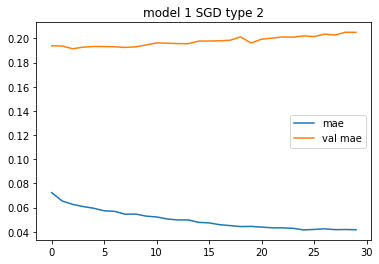

In [20]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 7ms/step
2682.785 2.0600739 3471.3377824694617


,date,actual,prediction
0,2021-05-20,129550,122750.390625
1,2021-05-21,128900,122733.203125
2,2021-05-24,128500,122792.085938
3,2021-05-25,128350,122853.296875
4,2021-05-27,127950,122931.953125
...,...,...,...
229,2022-11-02,128700,127619.421875
230,2022-11-03,130950,127690.125000
231,2022-11-04,133850,127586.976562
232,2022-12-01,128450,127642.250000


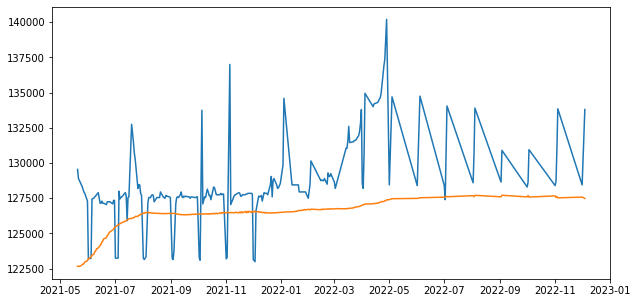

In [23]:
win_size1 = 60
test_beras_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_beras_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_beras_1 = pd.DataFrame()
data_new_beras_1['actual'] = x_test
data_new_beras_1['prediction'] = data_result_1
data_new_beras_1.to_csv('dagingsapi1_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_1.actual)
plt.plot(y_test, data_new_beras_1.prediction)
data_new_beras

#### type3

In [24]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 135ms/step - loss: 0.0041 - mae: 0.0318 - mape: 8.4054 - val_loss: 0.0597 - val_mae: 0.2053 - val_mape: 50.0733
Epoch 2/30
84/84 [==============================] - 11s 133ms/step - loss: 0.0041 - mae: 0.0318 - mape: 8.3476 - val_loss: 0.0595 - val_mae: 0.2049 - val_mape: 50.0855
Epoch 3/30
84/84 [==============================] - 11s 133ms/step - loss: 0.0041 - mae: 0.0318 - mape: 8.4102 - val_loss: 0.0596 - val_mae: 0.2051 - val_mape: 50.0800
Epoch 4/30
84/84 [==============================] - 11s 133ms/step - loss: 0.0041 - mae: 0.0318 - mape: 8.3935 - val_loss: 0.0597 - val_mae: 0.2054 - val_mape: 50.0705
Epoch 5/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0041 - mae: 0.0318 - mape: 8.3733 - val_loss: 0.0598 - val_mae: 0.2056 - val_mape: 50.0642
Epoch 6/30
84/84 [==============================] - 11s 132ms/step - loss: 0.0041 - mae: 0.0318 - mape: 8.3963 - val_loss: 0.0594 - val_mae: 0.2048 - val_mape: 

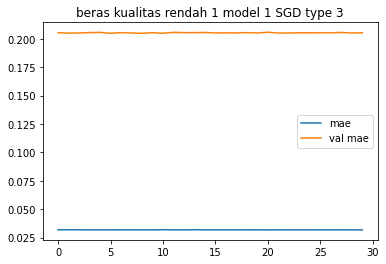

In [25]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('beras kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 13ms/step
2617.2273 2.0094793 3420.550540483213


,actual,prediction
0,129550,122743.054688
1,128900,122725.898438
2,128500,122784.742188
3,128350,122845.679688
4,127950,122924.296875
...,...,...
229,128700,127642.421875
230,130950,127712.859375
231,133850,127610.031250
232,128450,127665.117188


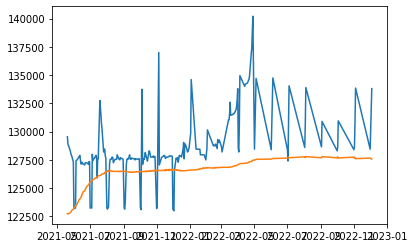

In [27]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_beras_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_beras_2 = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_2['actual'] = x_test
data_new_beras_2['prediction'] = data_result_2
data_new_beras_2.to_csv('dagingsapi1_model1_sgd_type3.csv')

plt.plot(y_test, data_new_beras_2.actual)
plt.plot(y_test, data_new_beras_2.prediction)
data_new_beras_2

### Adam

In [28]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [29]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 15s 248ms/step - loss: 0.1676 - mae: 0.4080 - mape: 96.0204 - val_loss: 0.2403 - val_mae: 0.4372 - val_mape: 89.5122
Epoch 2/30
44/44 [==============================] - 10s 216ms/step - loss: 0.1232 - mae: 0.3485 - mape: 81.8949 - val_loss: 0.1751 - val_mae: 0.3553 - val_mape: 66.7071
Epoch 3/30
44/44 [==============================] - 10s 217ms/step - loss: 0.0417 - mae: 0.1865 - mape: 43.6507 - val_loss: 0.0632 - val_mae: 0.2103 - val_mape: 49.5032
Epoch 4/30
44/44 [==============================] - 10s 218ms/step - loss: 0.0015 - mae: 0.0271 - mape: 6.3367 - val_loss: 0.0602 - val_mae: 0.2046 - val_mape: 49.6116
Epoch 5/30
44/44 [==============================] - 10s 218ms/step - loss: 0.0010 - mae: 0.0184 - mape: 4.2102 - val_loss: 0.0578 - val_mae: 0.1993 - val_mape: 49.7290
Epoch 6/30
44/44 [==============================] - 10s 216ms/step - loss: 0.0010 - mae: 0.0190 - mape: 4.3883 - val_loss: 0.0591 - val_mae: 0.2021 - val_map

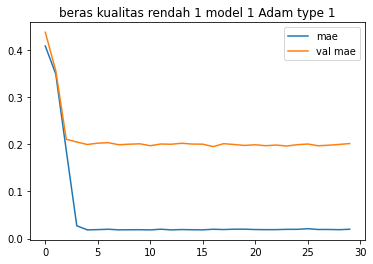

In [30]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 22ms/step
2522.541 1.9369854 3275.1963299930585


,actual,prediction
0,129550,124033.625000
1,128900,124027.031250
2,128500,124062.250000
3,128350,124086.132812
4,127950,124132.695312
...,...,...
229,128700,128169.148438
230,130950,128215.117188
231,133850,128152.625000
232,128450,128200.523438


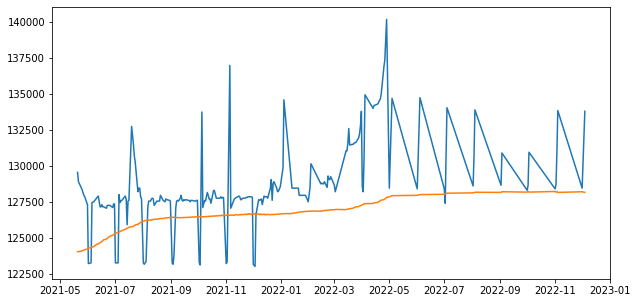

In [31]:
prediction_a = forecast_predict(model_a, test_beras_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_beras_a = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_a['actual'] = x_test
data_new_beras_a['prediction'] = data_result_a
data_new_beras_a.to_csv('dagingsapi1_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_beras_a.actual)
plt.plot(y_test, data_new_beras_a.prediction)
data_new_beras_a

#### Type 2

In [32]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0059 - mae: 0.0466 - mape: 18.5393 - val_loss: 0.0557 - val_mae: 0.1948 - val_mape: 49.7564
Epoch 2/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0057 - mae: 0.0462 - mape: 18.4716 - val_loss: 0.0608 - val_mae: 0.2064 - val_mape: 49.4330
Epoch 3/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0053 - mae: 0.0445 - mape: 17.1760 - val_loss: 0.0599 - val_mae: 0.2048 - val_mape: 49.4861
Epoch 4/30
718/718 [==============================] - 25s 34ms/step - loss: 0.0054 - mae: 0.0441 - mape: 17.3398 - val_loss: 0.0592 - val_mae: 0.2036 - val_mape: 49.4155
Epoch 5/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0053 - mae: 0.0432 - mape: 16.6337 - val_loss: 0.0577 - val_mae: 0.2005 - val_mape: 49.4320
Epoch 6/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0053 - mae: 0.0420 - mape: 16.3854 - val_loss: 0.0616 - val_mae: 0.2086 

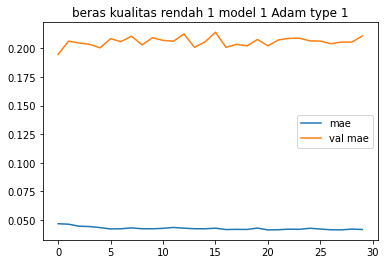

In [33]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
2946.7957 2.2663174 3630.5242045743203


,actual,prediction
0,129550,122203.625000
1,128900,122230.429688
2,128500,122291.640625
3,128350,122347.382812
4,127950,122431.421875
...,...,...
229,128700,127994.882812
230,130950,127841.484375
231,133850,127975.218750
232,128450,127854.140625


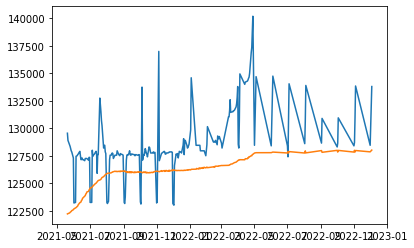

In [35]:
prediction_a1 = forecast_predict(model_a, test_beras_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_beras_a1 = pd.DataFrame()
data_new_beras_a1['actual'] = x_test
data_new_beras_a1['prediction'] = data_result_a1
data_new_beras_a1.to_csv('dagingsapi1_model1_adam_type2.csv')

plt.plot(y_test, data_new_beras_a1.actual)
plt.plot(y_test, data_new_beras_a1.prediction)
data_new_beras_a1

#### Type 3

In [36]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0041 - mae: 0.0322 - mape: 8.3951 - val_loss: 0.0608 - val_mae: 0.2071 - val_mape: 49.1147
Epoch 2/30
84/84 [==============================] - 11s 130ms/step - loss: 0.0040 - mae: 0.0316 - mape: 8.2865 - val_loss: 0.0598 - val_mae: 0.2052 - val_mape: 49.1424
Epoch 3/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0040 - mae: 0.0314 - mape: 8.2643 - val_loss: 0.0608 - val_mae: 0.2072 - val_mape: 49.0995
Epoch 4/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0041 - mae: 0.0322 - mape: 8.3790 - val_loss: 0.0596 - val_mae: 0.2047 - val_mape: 49.1371
Epoch 5/30
84/84 [==============================] - 11s 130ms/step - loss: 0.0040 - mae: 0.0318 - mape: 8.3094 - val_loss: 0.0581 - val_mae: 0.2016 - val_mape: 49.1814
Epoch 6/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0040 - mae: 0.0316 - mape: 8.2909 - val_loss: 0.0595 - val_mae: 0.2045 - val_mape: 

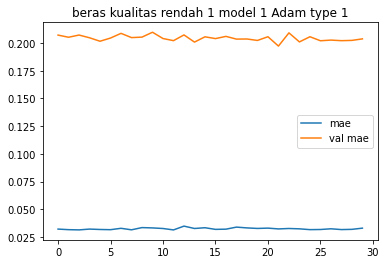

In [37]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 11ms/step
2704.2864 2.077017 3485.5827346370647


,actual,prediction
0,129550,122888.054688
1,128900,122871.601562
2,128500,122976.398438
3,128350,122975.414062
4,127950,123096.406250
...,...,...
229,128700,127545.195312
230,130950,127303.640625
231,133850,127557.617188
232,128450,127351.812500


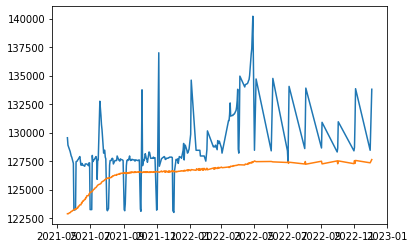

In [39]:
prediction_a2 = forecast_predict(model_a, test_beras_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_beras_a2 = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_a2['actual'] = x_test
data_new_beras_a2['prediction'] = data_result_a2
data_new_beras_a2.to_csv('dagingsapi1_model1_adam_type3.csv')

plt.plot(y_test, data_new_beras_a2.actual)
plt.plot(y_test, data_new_beras_a2.prediction)
data_new_beras_a2

## model 1

### Adam

In [40]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [41]:
history1 = model1.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 19s 338ms/step - loss: 0.0153 - mae: 0.0787 - mape: 18.5201 - val_loss: 0.0563 - val_mae: 0.1961 - val_mape: 50.8673
Epoch 2/100
44/44 [==============================] - 14s 313ms/step - loss: 0.0012 - mae: 0.0230 - mape: 5.2917 - val_loss: 0.0543 - val_mae: 0.1904 - val_mape: 51.0261
Epoch 3/100
44/44 [==============================] - 14s 313ms/step - loss: 0.0011 - mae: 0.0225 - mape: 5.2004 - val_loss: 0.0554 - val_mae: 0.1936 - val_mape: 50.9311
Epoch 4/100
44/44 [==============================] - 14s 310ms/step - loss: 0.0010 - mae: 0.0215 - mape: 4.9537 - val_loss: 0.0558 - val_mae: 0.1948 - val_mape: 50.8966
Epoch 5/100
44/44 [==============================] - 16s 358ms/step - loss: 0.0011 - mae: 0.0203 - mape: 4.6630 - val_loss: 0.0536 - val_mae: 0.1882 - val_mape: 51.0673
Epoch 6/100
44/44 [==============================] - 14s 311ms/step - loss: 0.0010 - mae: 0.0202 - mape: 4.6614 - val_loss: 0.0565 - val_mae: 0.1966 - val

17/17 [==============================] - 0s 22ms/step - loss: 0.0281 - mae: 0.1366 - mape: 30.2193


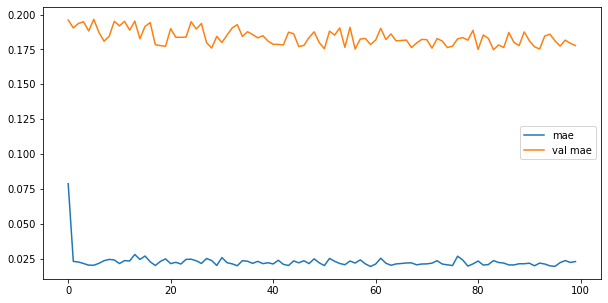

In [42]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [43]:
prediction1 = forecast_predict(model1, test_beras_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_beras1 = pd.DataFrame()
data_new_beras1['actual'] = x_test
data_new_beras1['prediction'] = data_result1
data_new_beras1.to_csv('dagingsapi1_model2_adam_type1.csv')

data_new_beras1

131/131 [==============================] - 7s 46ms/step
2718.4302 2.0837584 3591.8317054115996


,actual,prediction
0,129550,126066.882812
1,128900,126070.250000
2,128500,126069.328125
3,128350,126075.226562
4,127950,126079.484375
...,...,...
229,128700,126413.085938
230,130950,126394.835938
231,133850,126415.984375
232,128450,126396.929688


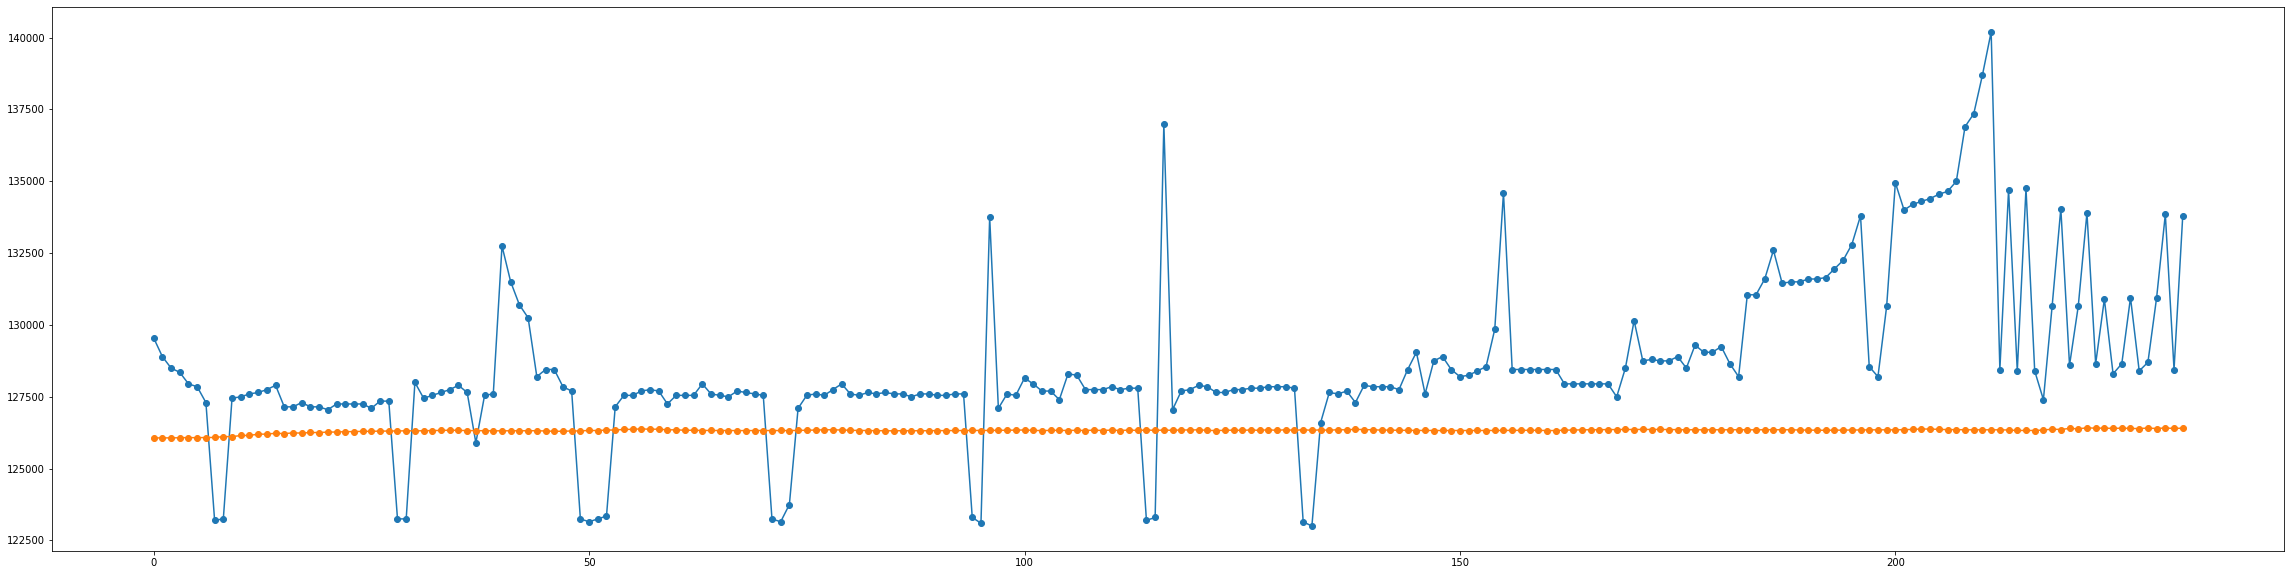

In [44]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_beras1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_beras1['prediction'], '-o')

#### Type 2

In [45]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 41s 57ms/step - loss: 0.0079 - mae: 0.0584 - mape: 23.2431 - val_loss: 0.0557 - val_mae: 0.1869 - val_mape: 48.5161
Epoch 2/15
718/718 [==============================] - 33s 46ms/step - loss: 0.0063 - mae: 0.0503 - mape: 19.7438 - val_loss: 0.0482 - val_mae: 0.1839 - val_mape: 55.6367
Epoch 3/15
718/718 [==============================] - 32s 45ms/step - loss: 0.0062 - mae: 0.0489 - mape: 18.9303 - val_loss: 0.0518 - val_mae: 0.1866 - val_mape: 50.0994
Epoch 4/15
718/718 [==============================] - 33s 46ms/step - loss: 0.0057 - mae: 0.0470 - mape: 17.9761 - val_loss: 0.0519 - val_mae: 0.1834 - val_mape: 49.6674
Epoch 5/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0057 - mae: 0.0477 - mape: 18.2951 - val_loss: 0.0447 - val_mae: 0.1749 - val_mape: 44.3147
Epoch 6/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0052 - mae: 0.0464 - mape: 17.4902 - val_loss: 0.0526 - val_mae: 0.1964 

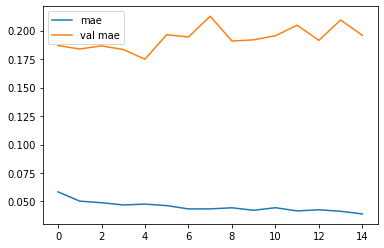

In [46]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 8ms/step
2745.214 2.105354 3591.8317054115996


,actual,prediction
0,129550,122518.351562
1,128900,122606.695312
2,128500,124525.312500
3,128350,124957.390625
4,127950,125310.070312
...,...,...
229,128700,126405.234375
230,130950,126535.898438
231,133850,126420.539062
232,128450,126578.804688


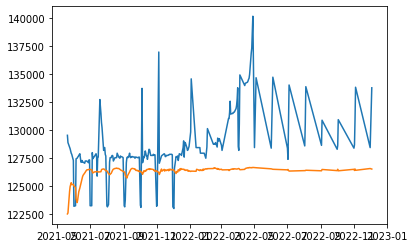

In [47]:
prediction1_1 = forecast_predict(model1, test_beras_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_beras1_1 = pd.DataFrame()
data_new_beras1_1['actual'] = x_test
data_new_beras1_1['prediction'] = data_result1_1
data_new_beras1_1.to_csv('dagingsapi1_model2_adam_type2.csv')

plt.plot(y_test, data_new_beras1_1.actual)
plt.plot(y_test, data_new_beras1_1.prediction)
data_new_beras1_1

#### Type 3

In [48]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 19s 222ms/step - loss: 0.0038 - mae: 0.0314 - mape: 8.1189 - val_loss: 0.0520 - val_mae: 0.1966 - val_mape: 44.2652
Epoch 2/15
84/84 [==============================] - 18s 210ms/step - loss: 0.0037 - mae: 0.0308 - mape: 7.9610 - val_loss: 0.0529 - val_mae: 0.1975 - val_mape: 44.1374
Epoch 3/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0036 - mae: 0.0313 - mape: 8.0894 - val_loss: 0.0526 - val_mae: 0.1968 - val_mape: 44.0584
Epoch 4/15
84/84 [==============================] - 17s 207ms/step - loss: 0.0037 - mae: 0.0311 - mape: 8.0521 - val_loss: 0.0539 - val_mae: 0.1983 - val_mape: 43.5119
Epoch 5/15
84/84 [==============================] - 18s 216ms/step - loss: 0.0038 - mae: 0.0328 - mape: 8.4200 - val_loss: 0.0544 - val_mae: 0.1995 - val_mape: 44.6071
Epoch 6/15
84/84 [==============================] - 18s 215ms/step - loss: 0.0036 - mae: 0.0314 - mape: 8.1239 - val_loss: 0.0533 - val_mae: 0.1959 - val_mape: 

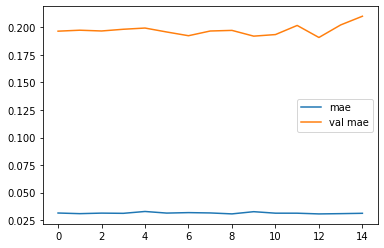

In [49]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 16ms/step
3197.9377 2.4547017 3591.8317054115996


,actual,prediction
0,129550,122641.093750
1,128900,122727.000000
2,128500,124671.656250
3,128350,125021.914062
4,127950,125149.195312
...,...,...
229,128700,125818.445312
230,130950,126057.460938
231,133850,125936.546875
232,128450,126087.562500


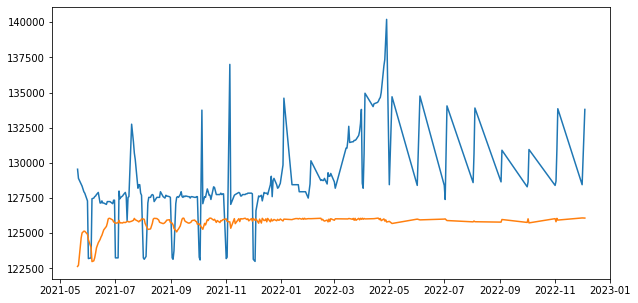

In [50]:
prediction1_2 = forecast_predict(model1, test_beras_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_beras1_2 = pd.DataFrame()
data_new_beras1_2['actual'] = x_test
data_new_beras1_2['prediction'] = data_result1_2
data_new_beras1_2.to_csv('dagingsapi1_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_2.actual)
plt.plot(y_test, data_new_beras1_2.prediction)

data_new_beras1_2

### SGD

In [51]:
model1_a= Sequential([
    # tf.keras.layers.Conv1D(97, kernel_size=5, 
    #                                        activation='relu',strides=2,
    #                                        input_shape=[None, 1]),
    #                 LSTM(24, return_sequences=True),
    #                 LSTM(64),
    #                 Dense(50, activation='relu'),
    #                 Dense(12, activation='relu'),
    #                 Dense(1)
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [52]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [53]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 19s 335ms/step - loss: 0.1559 - mae: 0.3934 - mape: 92.5421 - val_loss: 0.2278 - val_mae: 0.4225 - val_mape: 85.3923
Epoch 2/15
44/44 [==============================] - 14s 320ms/step - loss: 0.1232 - mae: 0.3493 - mape: 82.1173 - val_loss: 0.1964 - val_mae: 0.3835 - val_mape: 74.4720
Epoch 3/15
44/44 [==============================] - 14s 320ms/step - loss: 0.0982 - mae: 0.3115 - mape: 73.1724 - val_loss: 0.1708 - val_mae: 0.3487 - val_mape: 64.7440
Epoch 4/15
44/44 [==============================] - 14s 327ms/step - loss: 0.0782 - mae: 0.2777 - mape: 65.1796 - val_loss: 0.1498 - val_mae: 0.3183 - val_mape: 56.7507
Epoch 5/15
44/44 [==============================] - 14s 322ms/step - loss: 0.0621 - mae: 0.2471 - mape: 57.9590 - val_loss: 0.1322 - val_mae: 0.2923 - val_mape: 50.6582
Epoch 6/15
44/44 [==============================] - 14s 314ms/step - loss: 0.0489 - mae: 0.2187 - mape: 51.2207 - val_loss: 0.1177 - val_mae: 0.2750 - val_

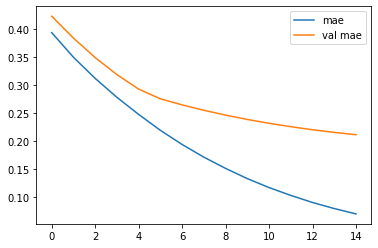

In [54]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 33ms/step
3198.194 2.454897 3968.7244802329124


,actual,prediction
0,129550,122643.382812
1,128900,122729.617188
2,128500,124675.742188
3,128350,125026.890625
4,127950,125148.664062
...,...,...
229,128700,125827.226562
230,130950,126059.195312
231,133850,125941.742188
232,128450,126088.187500


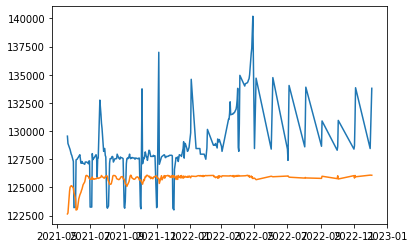

In [55]:
prediction1_a = forecast_predict(model1, test_beras_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_beras1_a = pd.DataFrame()
data_new_beras1_a['actual'] = x_test
data_new_beras1_a['prediction'] = data_result1_a
data_new_beras1_a.to_csv('dagingsapi1_model2_sgd_type1.csv')

plt.plot(y_test, data_new_beras1_a.actual)
plt.plot(y_test, data_new_beras1_a.prediction)

data_new_beras1_a

#### Type 2


In [56]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 32s 45ms/step - loss: 0.0105 - mae: 0.0799 - mape: 32.7582 - val_loss: 0.0594 - val_mae: 0.2014 - val_mape: 50.2982
Epoch 2/15
718/718 [==============================] - 31s 44ms/step - loss: 0.0108 - mae: 0.0812 - mape: 34.1076 - val_loss: 0.0587 - val_mae: 0.1998 - val_mape: 50.3331
Epoch 3/15
718/718 [==============================] - 34s 47ms/step - loss: 0.0105 - mae: 0.0789 - mape: 33.4533 - val_loss: 0.0585 - val_mae: 0.1995 - val_mape: 50.3410
Epoch 4/15
718/718 [==============================] - 33s 47ms/step - loss: 0.0101 - mae: 0.0772 - mape: 32.5098 - val_loss: 0.0580 - val_mae: 0.1983 - val_mape: 50.3504
Epoch 5/15
718/718 [==============================] - 32s 45ms/step - loss: 0.0100 - mae: 0.0762 - mape: 32.2792 - val_loss: 0.0576 - val_mae: 0.1975 - val_mape: 50.3628
Epoch 6/15
718/718 [==============================] - 33s 46ms/step - loss: 0.0097 - mae: 0.0747 - mape: 31.7836 - val_loss: 0.0572 - val_mae: 0.1964 

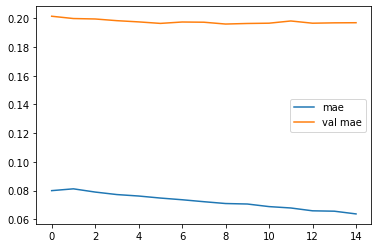

In [57]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 3s 10ms/step
3038.6997 2.3332632 3752.6875702621446


,actual,prediction
0,129550,124209.648438
1,128900,124221.843750
2,128500,124224.882812
3,128350,124264.796875
4,127950,124293.546875
...,...,...
229,128700,126678.968750
230,130950,126661.726562
231,133850,126646.195312
232,128450,126624.320312


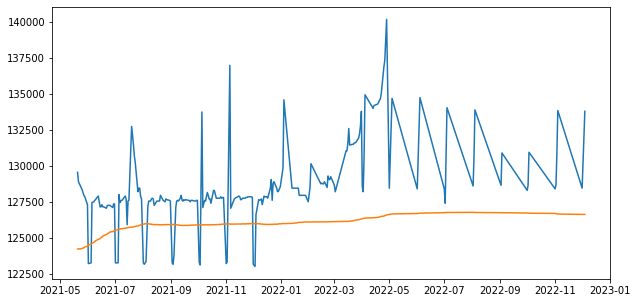

In [58]:
prediction1_a1 = forecast_predict(model1_a, test_beras_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_beras1_a1 = pd.DataFrame()
data_new_beras1_a1['actual'] = x_test
data_new_beras1_a1['prediction'] = data_result1_a1
data_new_beras1_a1.to_csv('dagingsapi1_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_a1.actual)
plt.plot(y_test, data_new_beras1_a1.prediction)
data_new_beras1_a1

#### Type 3

In [59]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 18s 218ms/step - loss: 0.0043 - mae: 0.0359 - mape: 9.4677 - val_loss: 0.0568 - val_mae: 0.1963 - val_mape: 50.4072
Epoch 2/15
84/84 [==============================] - 18s 215ms/step - loss: 0.0043 - mae: 0.0354 - mape: 9.3813 - val_loss: 0.0567 - val_mae: 0.1960 - val_mape: 50.4145
Epoch 3/15
84/84 [==============================] - 18s 218ms/step - loss: 0.0042 - mae: 0.0351 - mape: 9.3326 - val_loss: 0.0565 - val_mae: 0.1954 - val_mape: 50.4295
Epoch 4/15
84/84 [==============================] - 19s 223ms/step - loss: 0.0042 - mae: 0.0348 - mape: 9.2946 - val_loss: 0.0564 - val_mae: 0.1953 - val_mape: 50.4333
Epoch 5/15
84/84 [==============================] - 19s 226ms/step - loss: 0.0042 - mae: 0.0347 - mape: 9.2777 - val_loss: 0.0564 - val_mae: 0.1952 - val_mape: 50.4351
Epoch 6/15
84/84 [==============================] - 19s 224ms/step - loss: 0.0042 - mae: 0.0346 - mape: 9.2587 - val_loss: 0.0563 - val_mae: 0.1951 - val_mape: 

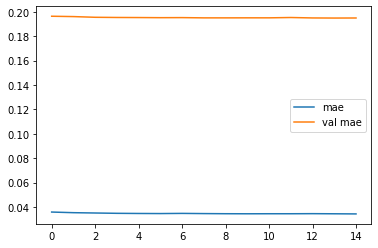

In [60]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 17ms/step
2856.4746 2.1925802 3602.0299832177966


,actual,prediction
0,129550,124388.523438
1,128900,124401.078125
2,128500,124403.695312
3,128350,124443.976562
4,127950,124472.820312
...,...,...
229,128700,126905.531250
230,130950,126888.554688
231,133850,126872.851562
232,128450,126850.804688


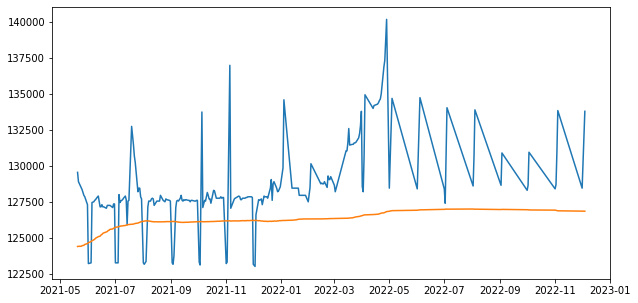

In [61]:
prediction1_a2 = forecast_predict(model1_a, test_beras_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_beras1_a2 = pd.DataFrame()
data_new_beras1_a2['actual'] = x_test
data_new_beras1_a2['prediction'] = data_result1_a2
data_new_beras1_a2.to_csv('dagingsapi1_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_a2.actual)
plt.plot(y_test, data_new_beras1_a2.prediction)

data_new_beras1_a2

## model 2

### SGD

In [62]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), loss='mean_squared_error', metrics=['mae'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [63]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [64]:
history2 = model2.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 11s 146ms/step - loss: 0.1809 - mae: 0.4242 - val_loss: 0.2738 - val_mae: 0.4738
Epoch 2/100
44/44 [==============================] - 6s 127ms/step - loss: 0.1810 - mae: 0.4242 - val_loss: 0.2738 - val_mae: 0.4737
Epoch 3/100
44/44 [==============================] - 5s 116ms/step - loss: 0.1808 - mae: 0.4241 - val_loss: 0.2737 - val_mae: 0.4736
Epoch 4/100
44/44 [==============================] - 5s 121ms/step - loss: 0.1808 - mae: 0.4241 - val_loss: 0.2736 - val_mae: 0.4735
Epoch 5/100
44/44 [==============================] - 6s 124ms/step - loss: 0.1807 - mae: 0.4239 - val_loss: 0.2735 - val_mae: 0.4735
Epoch 6/100
44/44 [==============================] - 6s 125ms/step - loss: 0.1806 - mae: 0.4238 - val_loss: 0.2735 - val_mae: 0.4734
Epoch 7/100
44/44 [==============================] - 6s 124ms/step - loss: 0.1806 - mae: 0.4237 - val_loss: 0.2734 - val_mae: 0.4733
Epoch 8/100
44/44 [==============================] - 6s 144ms/step -

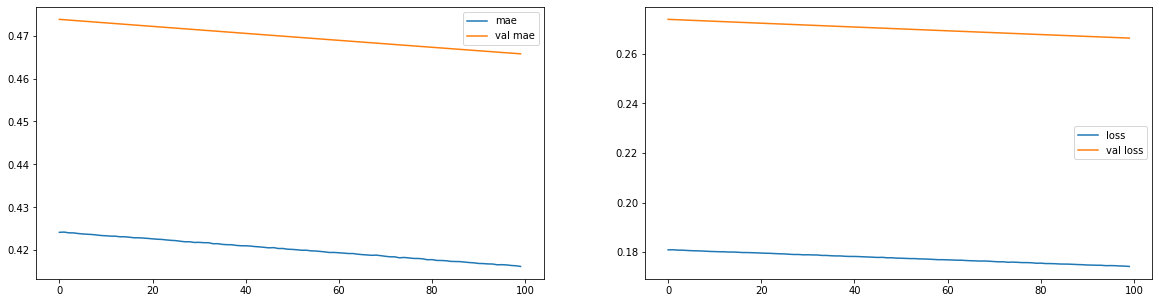

In [65]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 3s 17ms/step
12568.211 9.731707 12875.470010838439


,actual,prediction
0,129550,116016.078125
1,128900,116014.312500
2,128500,116015.937500
3,128350,116015.101562
4,127950,116016.289062
...,...,...
229,128700,116028.937500
230,130950,116034.171875
231,133850,116032.718750
232,128450,116035.046875


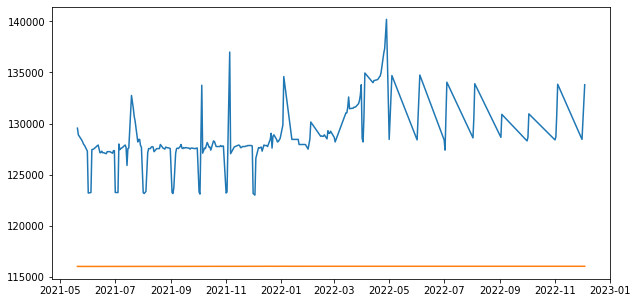

In [66]:
prediction2 = forecast_predict(model2, test_beras_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_beras2 = pd.DataFrame()
data_new_beras2['actual'] = x_test
data_new_beras2['prediction'] = data_result2
data_new_beras2.to_csv('dagingsapi1_model3_sgd-type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras2.actual)
plt.plot(y_test, data_new_beras2.prediction)
data_new_beras2

#### Type2

In [67]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 15s 21ms/step - loss: 0.1180 - mae: 0.3229 - val_loss: 0.2654 - val_mae: 0.4647
Epoch 2/50
718/718 [==============================] - 16s 22ms/step - loss: 0.1174 - mae: 0.3219 - val_loss: 0.2644 - val_mae: 0.4637
Epoch 3/50
718/718 [==============================] - 16s 23ms/step - loss: 0.1167 - mae: 0.3208 - val_loss: 0.2635 - val_mae: 0.4627
Epoch 4/50
718/718 [==============================] - 16s 23ms/step - loss: 0.1161 - mae: 0.3199 - val_loss: 0.2626 - val_mae: 0.4617
Epoch 5/50
718/718 [==============================] - 19s 26ms/step - loss: 0.1155 - mae: 0.3189 - val_loss: 0.2616 - val_mae: 0.4607
Epoch 6/50
718/718 [==============================] - 19s 27ms/step - loss: 0.1148 - mae: 0.3179 - val_loss: 0.2607 - val_mae: 0.4597
Epoch 7/50
718/718 [==============================] - 19s 27ms/step - loss: 0.1142 - mae: 0.3170 - val_loss: 0.2598 - val_mae: 0.4588
Epoch 8/50
718/718 [==============================] - 16s 22ms

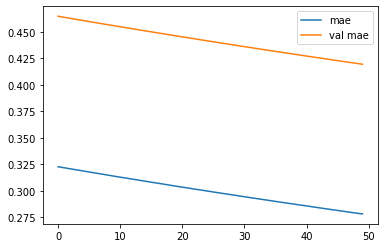

In [68]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [69]:
prediction2_1 = forecast_predict(model2, test_beras_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_beras2_1 = pd.DataFrame()
data_new_beras2_1['actual'] = x_test
data_new_beras2_1['prediction'] = data_result2_1
data_new_beras2_1.to_csv('dagingsapi1_model3_sgd_type2.csv')

data_new_beras2

199/199 [==============================] - 1s 5ms/step
11450.399 8.8620615 11786.743740321157


,actual,prediction
0,129550,116016.078125
1,128900,116014.312500
2,128500,116015.937500
3,128350,116015.101562
4,127950,116016.289062
...,...,...
229,128700,116028.937500
230,130950,116034.171875
231,133850,116032.718750
232,128450,116035.046875


#### Type 3

In [70]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 7s 83ms/step - loss: 0.1278 - mae: 0.3511 - val_loss: 0.2252 - val_mae: 0.4194
Epoch 2/50
84/84 [==============================] - 7s 81ms/step - loss: 0.1277 - mae: 0.3510 - val_loss: 0.2251 - val_mae: 0.4193
Epoch 3/50
84/84 [==============================] - 7s 82ms/step - loss: 0.1277 - mae: 0.3509 - val_loss: 0.2250 - val_mae: 0.4191
Epoch 4/50
84/84 [==============================] - 7s 82ms/step - loss: 0.1276 - mae: 0.3507 - val_loss: 0.2249 - val_mae: 0.4190
Epoch 5/50
84/84 [==============================] - 7s 80ms/step - loss: 0.1275 - mae: 0.3507 - val_loss: 0.2248 - val_mae: 0.4189
Epoch 6/50
84/84 [==============================] - 7s 80ms/step - loss: 0.1274 - mae: 0.3505 - val_loss: 0.2247 - val_mae: 0.4188
Epoch 7/50
84/84 [==============================] - 7s 78ms/step - loss: 0.1273 - mae: 0.3504 - val_loss: 0.2246 - val_mae: 0.4186
Epoch 8/50
84/84 [==============================] - 7s 79ms/step - loss: 0.1272 - m

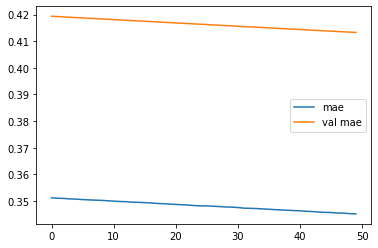

In [71]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [72]:
prediction2_2 = forecast_predict(model2, test_beras_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_beras2_2 = pd.DataFrame()
data_new_beras2_2['actual'] = x_test
data_new_beras2_2['prediction'] = data_result2_2
data_new_beras2_2.to_csv('dagingsapi1_model3_sgd_type3.csv')

data_new_beras2_2

181/181 [==============================] - 2s 10ms/step
11281.582 8.730747 11622.452753184243


,actual,prediction
0,129550,117269.929688
1,128900,117267.210938
2,128500,117268.921875
3,128350,117271.164062
4,127950,117272.226562
...,...,...
229,128700,117325.640625
230,130950,117329.640625
231,133850,117324.867188
232,128450,117332.140625


### Adam

In [73]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [74]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 11s 151ms/step - loss: 0.1202 - mae: 0.3410 - val_loss: 0.1379 - val_mae: 0.3004
Epoch 2/50
44/44 [==============================] - 6s 128ms/step - loss: 0.0115 - mae: 0.0808 - val_loss: 0.0697 - val_mae: 0.2199
Epoch 3/50
44/44 [==============================] - 6s 134ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 0.0669 - val_mae: 0.2155
Epoch 4/50
44/44 [==============================] - 6s 133ms/step - loss: 0.0013 - mae: 0.0235 - val_loss: 0.0665 - val_mae: 0.2149
Epoch 5/50
44/44 [==============================] - 6s 127ms/step - loss: 0.0013 - mae: 0.0237 - val_loss: 0.0664 - val_mae: 0.2146
Epoch 6/50
44/44 [==============================] - 6s 127ms/step - loss: 0.0012 - mae: 0.0230 - val_loss: 0.0658 - val_mae: 0.2136
Epoch 7/50
44/44 [==============================] - 6s 128ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 0.0668 - val_mae: 0.2153
Epoch 8/50
44/44 [==============================] - 6s 126ms/step - loss: 0

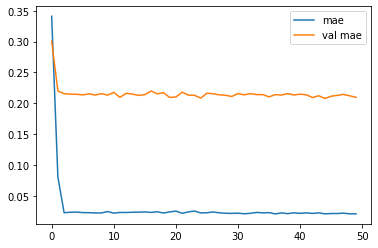

In [75]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [76]:
prediction2_a = forecast_predict(model2_a, test_beras_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_beras2_a = pd.DataFrame()
data_new_beras2_a['actual'] = x_test
data_new_beras2_a['prediction'] = data_result2_a
data_new_beras2_a.to_csv('dagingsapi1_model3_adam_type1.csv')

data_new_beras2_a

131/131 [==============================] - 4s 16ms/step
2406.6646 1.8473129 3198.1579072960108


,actual,prediction
0,129550,124386.640625
1,128900,124388.679688
2,128500,124404.468750
3,128350,124434.375000
4,127950,124426.132812
...,...,...
229,128700,128339.070312
230,130950,128385.773438
231,133850,128437.164062
232,128450,128417.773438


#### Type 2

In [77]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 16s 23ms/step - loss: 0.0063 - mae: 0.0490 - val_loss: 0.0584 - val_mae: 0.1995
Epoch 2/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0060 - mae: 0.0481 - val_loss: 0.0617 - val_mae: 0.2063
Epoch 3/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0057 - mae: 0.0457 - val_loss: 0.0682 - val_mae: 0.2177
Epoch 4/50
718/718 [==============================] - 16s 23ms/step - loss: 0.0054 - mae: 0.0452 - val_loss: 0.0612 - val_mae: 0.2054
Epoch 5/50
718/718 [==============================] - 17s 24ms/step - loss: 0.0055 - mae: 0.0449 - val_loss: 0.0653 - val_mae: 0.2130
Epoch 6/50
718/718 [==============================] - 17s 23ms/step - loss: 0.0056 - mae: 0.0466 - val_loss: 0.0640 - val_mae: 0.2108
Epoch 7/50
718/718 [==============================] - 17s 24ms/step - loss: 0.0052 - mae: 0.0442 - val_loss: 0.0592 - val_mae: 0.2016
Epoch 8/50
718/718 [==============================] - 17s 23ms

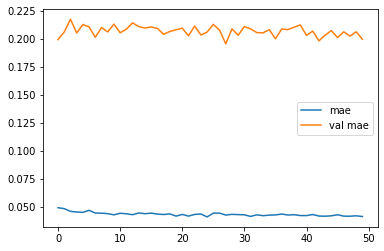

In [78]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 5ms/step
2754.0532 2.1166763 3485.1912429592726


,actual,prediction
0,129550,122864.609375
1,128900,122688.828125
2,128500,122990.835938
3,128350,122859.484375
4,127950,123056.835938
...,...,...
229,128700,128216.789062
230,130950,128157.398438
231,133850,128287.773438
232,128450,128200.617188


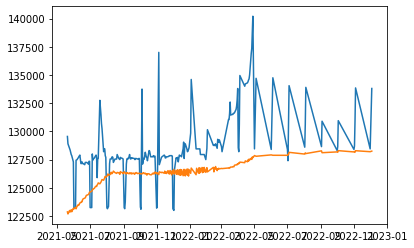

In [79]:
prediction2_a1 = forecast_predict(model2_a, test_beras_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_beras2_a1 = pd.DataFrame()
data_new_beras2_a1['actual'] = x_test
data_new_beras2_a1['prediction'] = data_result2_a1
data_new_beras2_a1.to_csv('dagingsapi1_model3_adam_type2.csv')

plt.plot(y_test, data_new_beras2_a1.actual)
plt.plot(y_test, data_new_beras2_a1.prediction)
data_new_beras2_a1

#### Type 3

In [80]:
history2_a2 = model2_a.fit(train_step2, epochs= 100, validation_data=val_step)

Epoch 1/100
84/84 [==============================] - 7s 84ms/step - loss: 0.0040 - mae: 0.0330 - val_loss: 0.0615 - val_mae: 0.2064
Epoch 2/100
84/84 [==============================] - 8s 90ms/step - loss: 0.0041 - mae: 0.0329 - val_loss: 0.0603 - val_mae: 0.2041
Epoch 3/100
84/84 [==============================] - 8s 90ms/step - loss: 0.0040 - mae: 0.0329 - val_loss: 0.0620 - val_mae: 0.2073
Epoch 4/100
84/84 [==============================] - 8s 91ms/step - loss: 0.0041 - mae: 0.0329 - val_loss: 0.0600 - val_mae: 0.2034
Epoch 5/100
84/84 [==============================] - 8s 89ms/step - loss: 0.0040 - mae: 0.0330 - val_loss: 0.0616 - val_mae: 0.2064
Epoch 6/100
84/84 [==============================] - 8s 90ms/step - loss: 0.0040 - mae: 0.0317 - val_loss: 0.0618 - val_mae: 0.2067
Epoch 7/100
84/84 [==============================] - 8s 88ms/step - loss: 0.0041 - mae: 0.0323 - val_loss: 0.0625 - val_mae: 0.2080
Epoch 8/100
84/84 [==============================] - 8s 88ms/step - loss: 0.

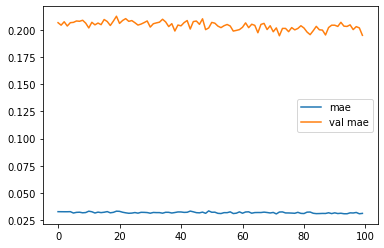

In [81]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

191/191 [==============================] - 1s 6ms/step
2667.4084 2.0472755 3570.9098280410276


,actual,prediction
0,129550,123600.640625
1,128900,123459.062500
2,128500,123672.890625
3,128350,123480.859375
4,127950,123652.078125
...,...,...
229,128700,127097.242188
230,130950,126919.312500
231,133850,127025.710938
232,128450,127149.117188


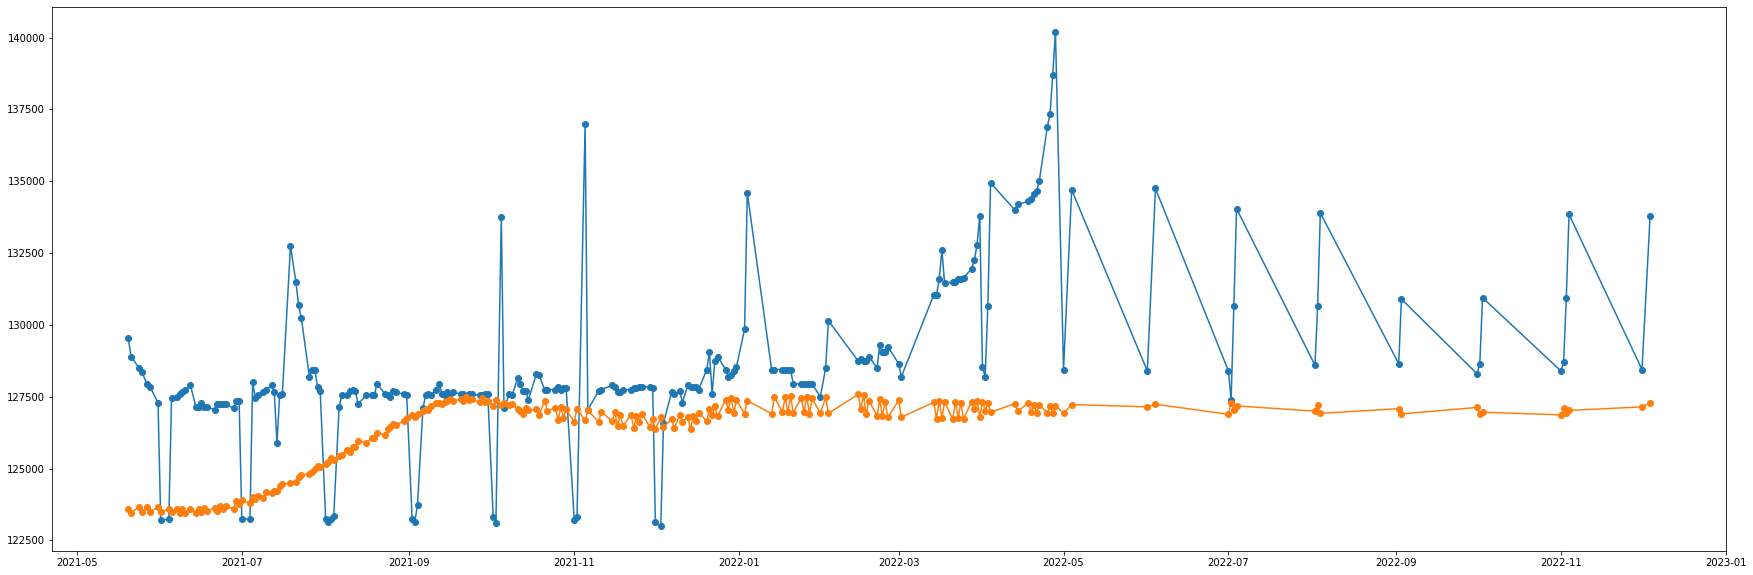

In [82]:
win_size = 100
prediction2_a2 = forecast_predict(model2_a, test_beras_, time_size=win_size, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_beras2_a2 = pd.DataFrame()
data_new_beras2_a2['actual'] = x_test
data_new_beras2_a2['prediction'] = data_result2_a2
data_new_beras2_a2.to_csv('dagingsapi1_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_beras2_a2.actual, '-o')
plt.plot(y_test,data_new_beras2_a2.prediction, '-o')
data_new_beras2_a2